# Poisonous Mushroom Classification

### Dataset description:

This dataset contains 8124 entries corresponding to 23 species of gilled mushrooms from North America. Each species is identified as definitely edible (e), definitely poisonous (p), or of unknown edibility and not recommended (also p). Each entry has 22 features related to the physical characteristics of the mushroom. The feature labels are explained in the file labels.txt. (Data source: The Audubon Society Field Guide to North American mushrooms)

### Importing all libraries

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Dataset: loading and initial inspection

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


We notice that the column _veil-type_ has only 1 unique value - that is, all 8124 mushroom instances have the same veil-color.

It thus becomes an irrelevant feature, so we proceed to remove it

In [4]:
df.drop(['veil-type'], axis=1, inplace=True)

### Converting categorical data to numerical

Most Machine Learning algorithms require _numerical features_. However, our dataset is composed of _categorical features_. We now proceed to convert these to numerical.

#### Label Encoding

A typical approach is to perform _Label Encoding_. This is nothing more than just assigning a number to each category, that is:

(cat_a, cat_b, cat_c, etc.) → (0, 1, 2, etc.)

This technique works:
* When the features are binary (only have 2 unique values)
* When the features are _ordinal categorical_ (that is, when the categories can be ranked). A good example would be a feature called _t-shirt size_ with 3 unique values _small_, _medium_ or _large_, which have an intrinsic order.

__However__, in our case, only some of our features have 2 unique values (most of them have more), and none of them are _ordinal categorical_ (in fact they they are _nominal categorical_, which means they have no intrinsic order).

Therefore, we will only apply Label Encoding to those features with a binary set of values:



In [5]:
for col in df.columns:
    if len(df[col].value_counts()) == 2:
        le = LabelEncoder()
        le.fit(df[col])
        df[col] = le.transform(df[col])
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,n,1,p,1,0,1,k,...,s,s,w,w,w,o,p,k,s,u
1,0,x,s,y,1,a,1,0,0,k,...,s,s,w,w,w,o,p,n,n,g
2,0,b,s,w,1,l,1,0,0,n,...,s,s,w,w,w,o,p,n,n,m
3,1,x,y,w,1,p,1,0,1,n,...,s,s,w,w,w,o,p,k,s,u
4,0,x,s,g,0,n,1,1,0,k,...,s,s,w,w,w,o,e,n,a,g


We can see how it has converted some of the features to values of 0 or 1. More importantly, our labels (the _class_ column) are now 0=e, and 1=p.

#### One Hot Encoding

For the remaining features, we can use a technique called One Hot Encoding.

Essentially, this consists on creating a new binary feature representing each category. For instance, from the feature _cap surface_, which has 4 unique values (f, g, y and s), we create 4 binary features (cap_surface_f, cap_surface_g, cap_surface_y and cap_surface_s) indicating whether the category they represent was indeed that one or not. This means that, for any given instance (row), we will have exactly one of these 4 features equal to 1, and the other 3 equal to 0.

One Hot Encoding is really simple to perform with the _pandas_ package:

In [6]:
df = pd.get_dummies(df)
df.head()

,class,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Separating labels from features

X will now contain our features, and y our labels (0 for edible and 1 for poisonous/unknown)

In [7]:
y = df['class'].to_frame()
X = df.drop('class', axis=1)

In [8]:
y.head()

,class
0,1
1,0
2,0
3,1
4,0


In [9]:
X.head()

,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Standardising our features

It is generally considered a _good practice_ to standardise our features (convert them to have zero-mean and unit variance). Most of the times, the difference will be small, but, in any case, it still never hurts to do so.

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Creating training and sets sets

We will separate our data into a training set (70%) and a test set (30%). This is a very standard approach in Machine Learning.

The _stratify_ option ensures that the ratio of edible to poisonois mushrooms in our dataset remains the same in both training and test sets. The *random_state* parameter is simply a seed for the algorithm to use (if we didn't specify one, it would create different training and test sets every time we run it)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=19)

### Logistic Regression

Since this is now a supervised learning binary classification problem, it makes perfect sense to start by running a simple _logistic regression_.

A logistic regression simply predicts the probability of an instance (row) belonging to the default class, which can then be snapped into a 0 or 1 classification. Off we go.

In [12]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())
y_pred_test = logreg.predict(X_test)
print('Accuracy of Logistic Regression classifier on the test set: {:.2f}'.format(accuracy_score(y_test, y_pred_test)))

Accuracy of Logistic Regression classifier on the test set: 1.00


It seems like the logistic regression achieved the maximum accuracy possible: 100%

I have to admit that this made me go back and check my code and logical reasoning a couple times. But no, it simply means that the given features are a really good indicator of the edibility of mushrooms.

Still, we should run the logistic regression again, but this time using _cross-validation_, to ensure that we are not overfitting the data. A simple 10-fold cross validation should do.


In [13]:
scores = cross_val_score(logreg, X_train, y_train.values.ravel(), cv=StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=19), scoring='accuracy')
print('Accuracy of Logistic Regression classifier using 10-fold cross-validation: {}'.format(scores.mean()))

Accuracy of Logistic Regression classifier using 10-fold cross-validation: 0.9997655334114889


This time it doesn't achieve the perfect score, but it's pretty damn close.

Thus, it seems like the relationship between the features and the edibility of the mushrooms is __highly linear__. There is really no point in trying other models different from this logistic regression.

What we can do is investigate what are the most immportant features in deciding whether a mushroom is edible or not.

### Most relevant features

In [14]:
features_coeffs = pd.DataFrame(logreg.coef_, columns=X.columns, index=['coefficients'])
features_coeffs.sort_values('coefficients', axis=1, ascending=False, inplace=True)
features_coeffs.T.head()

,coefficients
odor_p,1.301698
odor_c,1.248420
odor_f,1.215397
spore-print-color_r,1.186042
spore-print-color_h,1.101121


In [15]:
features_coeffs.T.tail()

,coefficients
gill-spacing,-0.777519
odor_a,-0.783296
spore-print-color_n,-0.819762
odor_l,-0.827127
odor_n,-1.719140


Interesting. Seems like _odor_ and _spore-print-color_ play an important role in deciding whether a mushroom is edible or not. Let's confirm this:

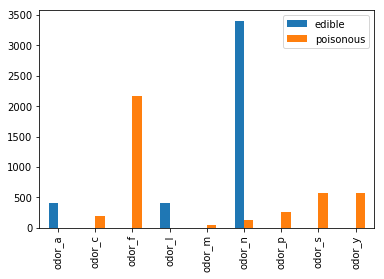

In [16]:
def plot_features_containing(feature_name):
    categories = X.columns[X.columns.str.contains(feature_name)]
    edible_num = []
    poisonous_num = []
    for cat in categories:
        y[X[cat]==0]
        edible_count = sum((y[X[cat]==1]==0).values[:,0])
        poisonous_count = sum(X[cat]==1) - edible_count
        edible_num.append(edible_count)
        poisonous_num.append(poisonous_count)
    odor_df = pd.DataFrame(index=categories, columns=['edible', 'poisonous'])
    odor_df.edible = edible_num
    odor_df.poisonous = poisonous_num
    odor_df.plot(x=odor_df.index, kind='bar')
plot_features_containing('odor')

odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s

Very interesting! Seems like, at least in our dataset set:
* All mushrooms with an almond or anise odor are edible
* All mushrooms with a creosote, fishy, musty, pungent or spicy odor are poisonous (or unknown edibility)
* Most mushrooms with no odor are edible. But not all of them!

Of course, this is just what our dataset tells us. It doesn't necessarily mean that any new mushroom we find out there will obey these rules 

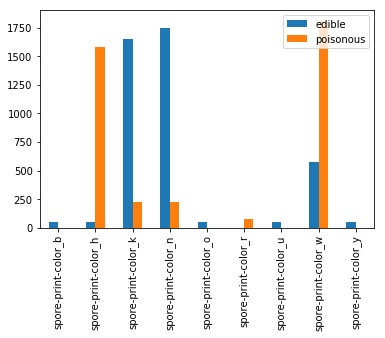

In [17]:
plot_features_containing('spore-print-color')

For _spore-print-color_ we have quite a similar picture, although perhaps not as extreme as with _odor_. This is what we expected, since these are the 2 features with the highest coefficients in our logistic regression.

In fact, if we do the same for a feature different from these two, the distribution will probably not be as extreme as for these last 2.

Let's check this.

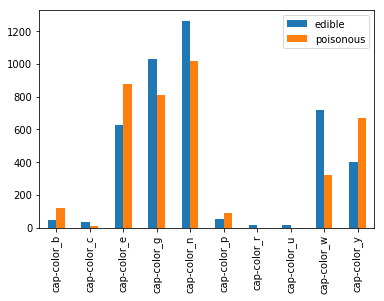

In [18]:
plot_features_containing('cap-color')

Indeed, we see a much more balanced distribution, which suggests that cap-color does not play such an important role in determining the edibility of a mushroom.

## Conclusion

* We fitted a logistic regression model and achieved near perfect accuracy, so there was no need to try with more complex models.

* Our algorithm identified specific traits (particularly regarding _odor_) that seem to heavily influence the chance that a mushroom is edible or not.

* Even though experts have determined that is that there is no simple set of rules to determine whether a mushroom is edible or not, it seems like with this algorithm we can get pretty close.

Nevertheless, it is important to keep in mind that __these results apply only to this dataset__, and don't necessarily mean that there aren't any mushrooms out there which don't follow these rules.

So, if you're ever lost and stranded in a forest, don't attempt to eat anything just because a machine tells you to do so! _Stay safe out there_.